# **Maize Leaf Disease Classification using Vision Transformer (ViT)**

<img src='https://imgs.search.brave.com/06oyAqYkjcVznl17oNdPhEMbiFV4DcV1YGrqbb52NGw/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9sZWFy/bm9wZW5jdi5jb20v/d3AtY29udGVudC91/cGxvYWRzLzIwMjMv/MDIvaW1hZ2UtOS0x/MDI0eDUzOC5wbmc'>

## **Import Dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import random

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import random_split, Dataset, DataLoader
import torch.nn.functional as F
from torchinfo import summary

from going_modular.going_modular import engine

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, torch.__version__)

# Define the directories
data_dir = 'datasets'

cuda 2.6.0+cu124


## **Define Configs**

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
RANDOM_SEED = 42

# Set the seed
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

## **Custom Dataset and DataLoader**

In [3]:
# Custom image dataset class
class CustomDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = glob(os.path.join(root_dir, 'data', '*', '*.jpg'))
        self.labels = []
        self.class_to_idx = {}

        for path in self.image_paths:
            label = path.split('\\')[-2]
            self.labels.append(label)

        for i, c in enumerate(set(self.labels)):
            self.class_to_idx[c] = i

        self.labels = [self.class_to_idx[l] for l in self.labels]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Define the transforms
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
# Create a custom dataset object
dataset = CustomDataset(data_dir, transform=manual_transforms)

# Split the data into training and testing
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

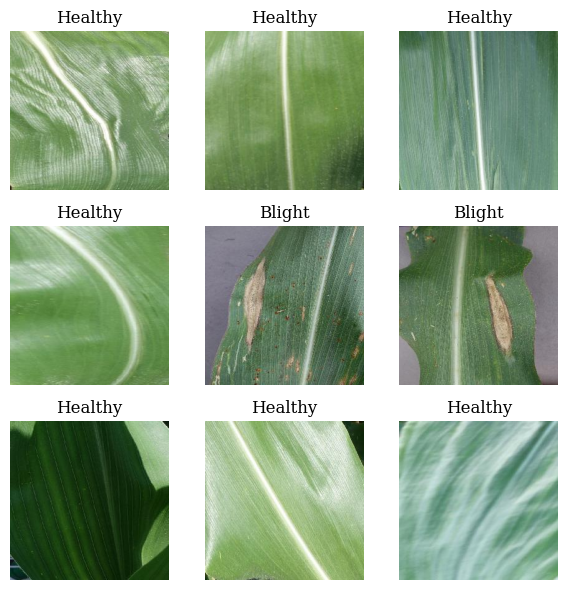

In [8]:
# Plot sample image
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
axes = axes.flatten()

for ax in axes:
    random_id = random.randint(0, len(train_dataset))
    img, label = train_dataset.__getitem__(random_id)
    img = img.permute(1, 2, 0).numpy()
    label_name = [k for k, v in dataset.class_to_idx.items() if label == v][0]
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Model Building**

### **`PatchEmbedding` class**

1. **Input:** Accepts an image tensor of shape **(B, C, H, W)** as input.

2. **Patch Extraction:** Uses `Conv2d` to split the image into non-overlapping patches.

3. **Flatten Patches:** Flattens the 2D patch grid into a 1D patch sequence.

4. **Permute Dimensions:** Reorders the output to **(B, N_patches, embedding_dim)** for transformer compatibility.

5. **Assertion Check:** Validates that image dimensions are divisible by the patch size.


In [9]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable encoding vector.

    Args:
        in_channels (int): Number of color channels in the input images. Defaults to 3.
        patch_size (int): Size of the patches to divide the image into. Defaults to 16.
        embedding_dim (int): Dimension of the output embedding. Defaults to 768.
    """
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        # Layer to convert image into non-overlapping patches and embed them
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Flatten patch feature maps into sequences
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # Check if input image resolution is divisible by patch size
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, \
            f"Input image size must be divisible by patch size, got image shape: {(image_resolution, image_resolution)}"

        # Apply patch embedding and flatten
        x = self.patcher(x)
        x = self.flatten(x)

        # Rearrange to (batch_size, num_patches, embedding_dim)
        return x.permute(0, 2, 1)

In [10]:
# Let's test it on a single image
# Create an object of the Patch Embedding
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through
image, label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Input image shape:', image.shape)

patch_embedded_image = patchify(image.unsqueeze(0))
print('Output patch embedding shape:', patch_embedded_image.shape)

Input image shape: torch.Size([3, 256, 256])
Output patch embedding shape: torch.Size([1, 256, 768])


In [11]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f'Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimensions]')

tensor([[[ 0.1094,  0.3339, -0.5404,  ...,  0.1842,  0.0473,  0.2403],
         [ 0.0910,  0.3347, -0.5384,  ...,  0.1567,  0.0366,  0.2179],
         [ 0.0890,  0.3081, -0.5335,  ...,  0.1655,  0.0416,  0.2426],
         ...,
         [ 0.0931,  0.3398, -0.5526,  ...,  0.1622,  0.0571,  0.2681],
         [ 0.1003,  0.3456, -0.5612,  ...,  0.1742,  0.0647,  0.2684],
         [ 0.0918,  0.3595, -0.5506,  ...,  0.1677,  0.0510,  0.2688]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 256, 768]) -> [batch_size, number_of_patches, embedding_dimensions]


### **Transformer Encoder**

#### **`Multi-Head Attention` Block**

In [12]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block with LayerNorm and residual connection.
    """

    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attn_dropout: float = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_norm = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x_norm, key=x_norm, value=x_norm)
        return x + attn_output  # Residual connection


#### **`MLP` Block**

In [13]:

class MLPBlock(nn.Module):
    """
    Creates a layer-normalized MLP block with residual connection.
    """

    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, dropout: float = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_norm = self.layer_norm(x)
        return x + self.mlp(x_norm)  # Residual connection


#### **Transformer Encoder by Combining Custom Made Layers**

In [14]:
class TransformerEncoderBlock(nn.Module):
    """
    Combines MSA and MLP blocks into a Transformer Encoder block.
    """

    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, mlp_size: int = 3072,
                 mlp_dropout: float = 0.1, attn_dropout: float = 0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x)
        x = self.mlp_block(x)
        return x


In [15]:
# Plot the summary of the Transformer encoder
transformer_encoder_block =TransformerEncoderBlock()

summary(
    model=transformer_encoder_block,
    input_size=(1, 257, 768), # (batch_size, num_patches, embedding dimension),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 257, 768]        [1, 257, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 257, 768]        [1, 257, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 257, 768]        [1, 257, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 257, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 257, 768]        [1, 257, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 257, 768]        [1, 257, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 257, 768]        [1, 257, 768]        --                   True
│    │    └─Linear (0)                     

### **`VisionTransformer`**

In [17]:
class ViT(nn.Module):
    """
    Creates a Vision Transformer architecture with ViT-Base hyperparameters by default
    """
    def __init__(self,
                 img_size:int=256,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        # Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f'Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}'

        # Calculate number of patches (height * width / patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # Learnable positional embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                                 requires_grad=True)
        
        # Embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # Forward method
    
    def forward(self, x):
        batch_size = x.shape[0]

        # Create and expand class token
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Apply patch embedding
        x = self.patch_embedding(x)

        # Concatenate class token
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding and dropout
        x = x + self.position_embedding
        x = self.embedding_dropout(x)

        # Pass through Transformer encoder
        x = self.transformer_encoder(x)

        # Use [CLS] token for classification
        return self.classifier(x[:, 0])

## **Training**

In [21]:
# Create ViT model and move to device
vit = ViT(num_classes=len(dataset.class_to_idx)).to(device)

# Setup optimizer with a better learning rate
optimizer = torch.optim.AdamW(params=vit.parameters(),
                              lr=3e-4,  # more stable
                              betas=(0.9, 0.999),
                              weight_decay=0.3)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# # Train the model
# results = engine.train(model=vit,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=50,
#                        device=device)